In [2]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pandas as pd

from datetime import datetime, timedelta

from keras.models import Sequential
from keras.layers import LSTM, Dense
import pandas as pd 

import yaml
import matplotlib.pyplot as plt
import numpy as np

import os


In [3]:
d = pd.read_csv('energy_cons_dataset\DAYTON_hourly.csv')
#converting into datetime object
d['Datetime']=pd.to_datetime(d['Datetime'])
#d.head()
d = d.groupby('Datetime', as_index=False)['DAYTON_MW'].mean()
d.sort_values('Datetime', inplace=True)

In [4]:
d.head()

,Datetime,DAYTON_MW
0,2004-10-01 01:00:00,1621.0
1,2004-10-01 02:00:00,1536.0
2,2004-10-01 03:00:00,1500.0
3,2004-10-01 04:00:00,1434.0
4,2004-10-01 05:00:00,1489.0


In [5]:

class DeepModelTS():
   
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
       
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

    
        model.fit(
            **keras_dict
        )

        self.model = model

        return model

    def predict(self) -> list:
        
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, Y_test= self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat 

    def predict_n_ahead(self, n_ahead: int):
        
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

     
        yhat = []

        for _ in range(n_ahead):
        
            fc = self.model.predict(X)
            yhat.append(fc)

            
            X = np.append(X, fc)
            X = np.delete(X, 0)

            
            X = np.reshape(X, (1, len(X), 1))

          
        return yhat    

In [6]:
#full data se forecasting and n step ahead dena
deep_learner = DeepModelTS(
data=d,
Y_var='DAYTON_MW',
lag=48,
LSTM_layer_depth=64,
epochs=10,
train_test_split=0
)

# Fitting the model
deep_learner.LSTModel()
# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

Epoch 1/10
121223/121223 [==============================] - 65s 533us/step - loss: 220837.3056
Epoch 2/10
121223/121223 [==============================] - 62s 514us/step - loss: 78231.2289
Epoch 3/10
121223/121223 [==============================] - 69s 568us/step - loss: 67429.3382
Epoch 4/10
121223/121223 [==============================] - 61s 501us/step - loss: 56596.6825
Epoch 5/10
121223/121223 [==============================] - 60s 492us/step - loss: 39269.0534
Epoch 6/10
121223/121223 [==============================] - 65s 538us/step - loss: 27728.0917
Epoch 7/10
121223/121223 [==============================] - 64s 531us/step - loss: 23520.8163
Epoch 8/10
121223/121223 [==============================] - 64s 526us/step - loss: 20506.1398
Epoch 9/10
121223/121223 [==============================] - 61s 505us/step - loss: 18792.8531
Epoch 10/10
121223/121223 [==============================] - 64s 530us/step - loss: 167677.2960


In [10]:
fc
#print(fc.shape)

,Datetime,DAYTON_MW,type
0,2018-07-17 09:00:00,2251.000000,original
1,2018-07-17 10:00:00,2365.000000,original
2,2018-07-17 11:00:00,2486.000000,original
3,2018-07-17 12:00:00,2568.000000,original
4,2018-07-17 13:00:00,2692.000000,original
...,...,...,...
563,2018-08-09 20:00:00,2070.586914,forecast
564,2018-08-09 21:00:00,1717.215820,forecast
565,2018-08-09 22:00:00,2057.641602,forecast
566,2018-08-09 23:00:00,2099.655518,forecast


In [11]:
d.tail(1) # to check last date 

,Datetime,DAYTON_MW
121270,2018-08-03,2042.0


In [16]:
display(fc.iloc[400])
#iske aage se forecasting 


Datetime     2018-08-03 01:00:00
DAYTON_MW                1929.51
type                    forecast
Name: 400, dtype: object

In [17]:
fc = d.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['Datetime'])
hat_frame = pd.DataFrame({
    'Datetime': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'DAYTON_MW': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)

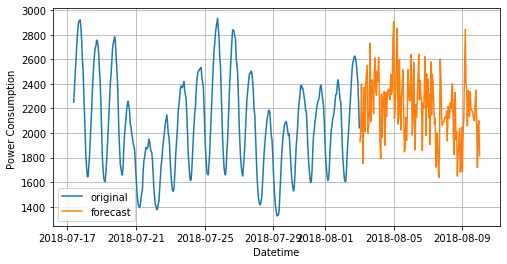

In [18]:
#plot karo
plt.figure(figsize=(8, 4))
for col_type in ['original', 'forecast']:
    plt.plot(
        'Datetime', 
        'DAYTON_MW', 
        data=fc[fc['type']==col_type],
        label=col_type
        )
plt.xlabel("Datetime")
plt.ylabel("Power Consumption ")
plt.legend()
plt.grid()
plt.show()    